In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, Activation, UpSampling1D
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D, LayerNormalization, Add
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D
from keras import  backend as K
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

    '''
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot
    '''

In [8]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


In [9]:
print(trainX)
print(trainy)

[[[ 1.012817e+00 -1.232167e-01  1.029341e-01 ...  3.019122e-02
    6.601362e-02  2.285864e-02]
  [ 1.022833e+00 -1.268756e-01  1.056872e-01 ...  4.371071e-02
    4.269897e-02  1.031572e-02]
  [ 1.022028e+00 -1.240037e-01  1.021025e-01 ...  3.568780e-02
    7.485018e-02  1.324969e-02]
  ...
  [ 1.018445e+00 -1.240696e-01  1.003852e-01 ...  3.985177e-02
    1.909445e-03 -2.170124e-03]
  [ 1.019372e+00 -1.227451e-01  9.987355e-02 ...  3.744932e-02
   -7.982483e-05 -5.642633e-03]
  [ 1.021171e+00 -1.213260e-01  9.498741e-02 ...  2.881781e-02
   -3.771800e-05 -1.446006e-03]]

 [[ 1.018851e+00 -1.239760e-01  9.792958e-02 ...  1.711106e-02
    6.122797e-03  1.226815e-02]
  [ 1.022380e+00 -1.268078e-01  9.935086e-02 ...  2.417851e-02
    9.710357e-03  1.614958e-02]
  [ 1.020781e+00 -1.277862e-01  9.811381e-02 ...  3.022889e-02
    1.032192e-02  1.589471e-02]
  ...
  [ 1.014788e+00 -1.290268e-01  9.353520e-02 ... -3.474078e-02
   -8.694754e-03  5.044730e-03]
  [ 1.016499e+00 -1.264244e-01  8.90

In [10]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)


In [11]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [12]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [13]:
# trainy에서 값이 0, 1, 2인 행의 인덱스 찾기
indices_to_remove = np.where((trainy == 0) | (trainy == 1) | (trainy == 2))[0]

# trainX와 trainy에서 해당 인덱스를 제거하여 새로운 trainX_filtered와 trainy_filtered 얻기
trainX_filtered = np.delete(trainX, indices_to_remove, axis=0)
trainy_filtered = np.delete(trainy, indices_to_remove, axis=0)

# trainX_filtered와 trainy_filtered의 shape 확인
print("Shape of trainX_filtered:", trainX_filtered.shape)
print("Shape of trainy_filtered:", trainy_filtered.shape)

Shape of trainX_filtered: (4067, 128, 9)
Shape of trainy_filtered: (4067, 1)


In [14]:
# trainy에서 값이 3인 것을 0으로, 값이 4인 것을 1로, 값이 5인 것을 2로 변경
trainy_filtered[trainy_filtered == 3] = 0
trainy_filtered[trainy_filtered == 4] = 1
trainy_filtered[trainy_filtered == 5] = 2

# 변경된 trainy_filtered의 값 확인
print("Modified trainy_filtered:\n", trainy_filtered)

Modified trainy_filtered:
 [[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [15]:
# trainy에서 값이 0, 1, 2인 행의 인덱스 찾기
indices_to_remove = np.where((testy == 0) | (testy == 1) | (testy == 2))[0]

# trainX와 trainy에서 해당 인덱스를 제거하여 새로운 trainX_filtered와 trainy_filtered 얻기
testX_filtered = np.delete(testX, indices_to_remove, axis=0)
testy_filtered = np.delete(testy, indices_to_remove, axis=0)

# trainX_filtered와 trainy_filtered의 shape 확인
print("Shape of testX_filtered:", testX_filtered.shape)
print("Shape of testy_filtered:", testy_filtered.shape)

Shape of testX_filtered: (1560, 128, 9)
Shape of testy_filtered: (1560, 1)


In [16]:
# trainy에서 값이 3인 것을 0으로, 값이 4인 것을 1로, 값이 5인 것을 2로 변경
testy_filtered[testy_filtered == 3] = 0
testy_filtered[testy_filtered == 4] = 1
testy_filtered[testy_filtered == 5] = 2

# 변경된 trainy_filtered의 값 확인
print("Modified testy_filtered:\n", testy_filtered)

Modified testy_filtered:
 [[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [17]:
trainy_one_hot = to_categorical(trainy_filtered)
testy_one_hot = to_categorical(testy_filtered)
print(trainy_filtered)
print(testy_filtered)

[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]
[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [18]:
print("X train shape: ", trainX_filtered.shape)
print("Y train shape: ", trainy_filtered.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX_filtered.shape)
print("Y test shape: ", testy_filtered.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [19]:
print("0: Sitting:" ,np.where(trainy_filtered == 0)[0].size)
print("1: Standing:" ,np.where(trainy_filtered == 1)[0].size)
print("2: Laying:" ,np.where(trainy_filtered == 2)[0].size)

0: Sitting: 1286
1: Standing: 1374
2: Laying: 1407


In [20]:
unique, counts = np.unique(trainy_filtered, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy_filtered, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1286]
 [   1 1374]
 [   2 1407]]
Test data label statistics::
[[  0 491]
 [  1 532]
 [  2 537]]


In [21]:
X_train_all = trainX_filtered   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy_filtered

X_test_all = testX_filtered
y_test_all = testy_filtered

In [22]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX_filtered, testX_filtered):
 # remove overlap
 cut = int(trainX_filtered.shape[1] / 2)
 longX = trainX_filtered[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX_filtered.reshape((trainX_filtered.shape[0] * trainX_filtered.shape[1], trainX_filtered.shape[2]))
 flatTestX = testX_filtered.reshape((testX_filtered.shape[0] * testX_filtered.shape[1], testX_filtered.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX_filtered.shape))
 flatTestX = flatTestX.reshape((testX_filtered.shape))
 return flatTrainX, flatTestX

In [23]:
trainX, testX = scale_data(trainX_filtered, testX_filtered)

In [24]:
print("X train shape: ", trainX_filtered.shape)
print("Y train shape: ", trainy_filtered.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX_filtered.shape)
print("Y test shape: ", testy_filtered.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [25]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX_filtered, trainy_one_hot, trainy_filtered,test_size=0.3,random_state=100)

In [26]:
n_timesteps, n_features, n_outputs = trainX_filtered.shape[1], trainX_filtered.shape[2], trainy_one_hot.shape[1]

In [30]:
def SE_Block(inputs, num_filters, ratio):
    squeeze = tf.keras.layers.GlobalAveragePooling1D()(inputs)

    excitation = tf.keras.layers.Dense(units=num_filters/ratio)(squeeze)
    excitation = tf.keras.layers.Activation('relu')(excitation)
    excitation = tf.keras.layers.Dense(units=num_filters)(excitation)
    excitation = tf.keras.layers.Activation('sigmoid')(excitation)
    excitation = tf.keras.layers.Reshape([1, num_filters])(excitation)

    scale = inputs * excitation

    return scale

In [31]:
def Conv_1D_Block(inputs, num_filters, kernel, strides):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(num_filters, kernel, strides=strides, padding="same", kernel_initializer="he_normal")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [32]:
def residual_block(inputs, num_filters, ratio):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = inputs
    #
    conv = Conv_1D_Block(inputs, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = SE_Block(conv, num_filters, ratio)
    conv = tf.keras.layers.Add()([conv, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)

    return out

In [33]:
def ResBlock(inputs, num_units):
    x = Dense(num_units, activation='relu')(inputs)
    x = Dense(num_units, activation='relu')(x)
    res = Add()([x, inputs])
    return res

## SEblock

In [39]:
num_filters = 3
ratio = 1
num_units = 9

inputs= Input(shape=(n_timesteps,n_features))

residual_output = ResBlock(inputs, num_units)
conv1  = Conv1D(filters=64, kernel_size=3, activation='relu')(residual_output)

x = Flatten()(conv1)
x = Dense(128, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 128, 9)               90        ['input_4[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 128, 9)               90        ['dense_8[0][0]']             
                                                                                                  
 add_2 (Add)                 (None, 128, 9)               0         ['dense_9[0][0]',             
                                                                     'input_4[0][0]']         

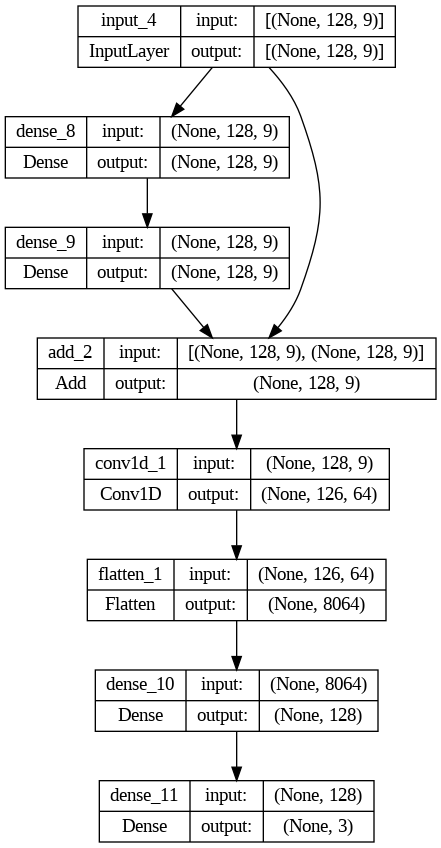

In [40]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [41]:
# validation_split = 0.1
batch_size = 128

train_epochs = 30
history = model.fit(trainX_filtered, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,
                    validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/30
32/32 [==============================] - 6s 106ms/step - loss: 0.2904 - accuracy: 0.8672 - val_loss: 0.1981 - val_accuracy: 0.9247
Epoch 2/30
32/32 [==============================] - 3s 81ms/step - loss: 0.1974 - accuracy: 0.9122 - val_loss: 0.2392 - val_accuracy: 0.9009
Epoch 3/30
32/32 [==============================] - 3s 90ms/step - loss: 0.1954 - accuracy: 0.9162 - val_loss: 0.1818 - val_accuracy: 0.9140
Epoch 4/30
32/32 [==============================] - 2s 55ms/step - loss: 0.1813 - accuracy: 0.9196 - val_loss: 0.1755 - val_accuracy: 0.9271
Epoch 5/30
32/32 [==============================] - 2s 57ms/step - loss: 0.1774 - accuracy: 0.9243 - val_loss: 0.1709 - val_accuracy: 0.9271
Epoch 6/30
32/32 [==============================] - 2s 50ms/step - loss: 0.1761 - accuracy: 0.9248 - val_loss: 0.1667 - val_accuracy: 0.9238
Epoch 7/30
32/32 [==============================] - 2s 57ms/step - loss: 0.1734 - accuracy: 0.9245 - val_loss: 0.1606 - val_accuracy: 0.9263
Epoch 8/30
3

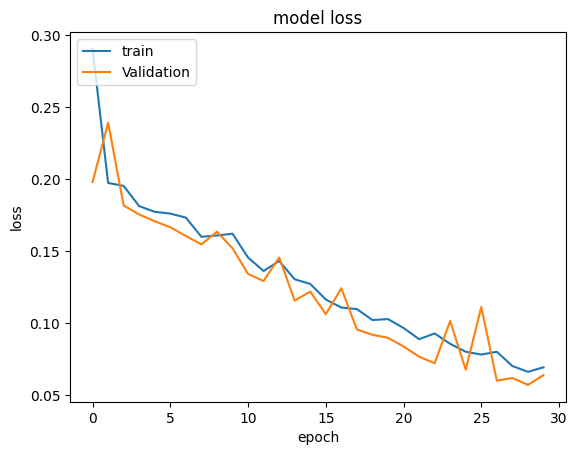

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

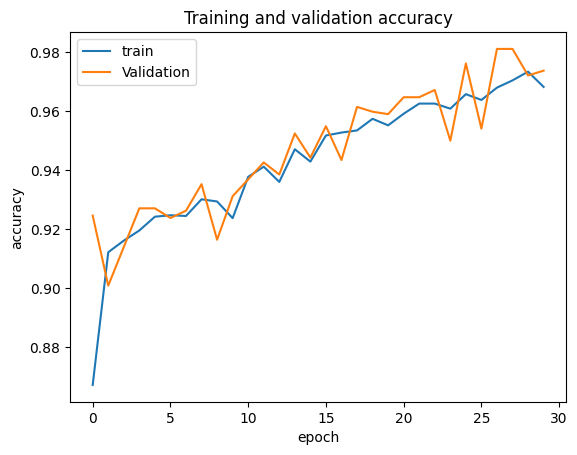

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 12ms/step
[[421  66   4]
 [ 67 465   0]
 [  0  26 511]]
0.8955128205128206
0.8963470978129084
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       491
           1       0.83      0.87      0.85       532
           2       0.99      0.95      0.97       537

    accuracy                           0.90      1560
   macro avg       0.90      0.89      0.90      1560
weighted avg       0.90      0.90      0.90      1560



<Axes: >

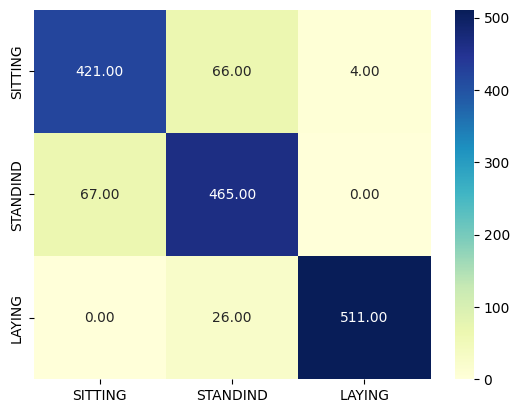

In [44]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX_filtered)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy_filtered,predy)
print(cm)
print(accuracy_score(testy_filtered,predy))
print(f1_score(testy_filtered,predy, average='weighted'))
print(classification_report(testy_filtered,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')